In [ ]:
pip install smogn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import smogn
import random
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from pandas.errors import PerformanceWarning

warnings.simplefilter(action="ignore", category=PerformanceWarning)


In [ ]:
df = pd.read_excel('/content/deduplicated_by_mode.xlsx')

columns_to_drop = [
    "Continent", "NCC-16-cases", "NCC-18-cases", "Low CIN-16-cases", "Low CIN-18-cases",
    "High CIN-16-cases", "High CIN-18-cases", "ICC - 16 - any - cases", "ICC - 16 - SCC - cases",
    "ICC - 16 - ADC - cases", "ICC - 18 - any - cases", "ICC - 18 - SCC - cases",
    "ICC - 18 - ADC - cases", 'Sample size studied', 'ICC prevalence',
    'High CIN prevalence', 'Low CIN prevalence'
]
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)


In [ ]:
df["TB_Incidence_Percent"] = (df["Incidence of TB"] / df["Population estimate"]) * 100
disease_cols = ["TB_Incidence_Percent", "Hypertension", "Diabetes Prevalence"]
df_norm = df[disease_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df["Disease_Incidence_Score"] = df_norm.mean(axis=1)
df.drop(columns=disease_cols, inplace=True)


In [ ]:
def convert_screening_year(value):
    if pd.isnull(value): return np.nan
    if isinstance(value, str) and value.strip().lower() in ["not started", "unknown"]:
        return 0
    try: return int(value)
    except: return np.nan

df["Screening_Start_Year"] = df["Start of Screening coverage (year)"].apply(convert_screening_year)

circumcision_col = "Male circumcision (WHO 2007)"
if circumcision_col in df.columns:
    df["Male circumcision category"] = df[circumcision_col].map({"<20": "Low", "20-80": "Medium", ">80": "High"})
    df.drop(columns=[circumcision_col], inplace=True)

sti_cols = [
    'STI_SyphilisRate_rateper100k_2021',
    'STI_ChlamydialInfectionRate_rateper100k_2021',
    'STDRates_GonococcalInfectionRate_rateper100k_2021'
]
df_sti_norm = df[sti_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df['STI_Score'] = df_sti_norm.mean(axis=1)
df.drop(columns=sti_cols, inplace=True)


In [ ]:

df['Low_CIN_combined'] = df[['Low CIN-16-prevalence', 'Low CIN-18-prevalence']].mean(axis=1, skipna=True)

# Step 2: Now drop all unnecessary columns
df.drop(columns=[
    "NCC-16-prevalence", "NCC-18-prevalence", "Low CIN-16-prevalence", "Low CIN-18-prevalence",
    "High CIN-16-prevalence", "High CIN-18-prevalence", "ICC - 16 - any - prevalence",
    "ICC - 16 - SCC - prevalence", "ICC - 16 - ADC - prevalence", "ICC - 18 - any - prevalence",
    "ICC - 18 - SCC - prevalence", "ICC - 18 - ADC - prevalence", "Start of Screening coverage (year)"
], inplace=True)

# Step 3: Drop rows with no Low_CIN_combined value
df = df.dropna(subset=["Low_CIN_combined"])


In [ ]:
X_all = df.drop(columns=["Low_CIN_combined"])
y_all = df["Low_CIN_combined"]

X_all = X_all.drop(columns=['Country', 'economy'], errors='ignore')  # Avoid high-cardinality dummy vars
X_encoded = pd.get_dummies(X_all, drop_first=True)

imputer = SimpleImputer(strategy='median')
X_encoded_imputed = imputer.fit_transform(X_encoded)

lasso = LassoCV(cv=5, random_state=42).fit(X_encoded_imputed, y_all)
selector = SelectFromModel(lasso, threshold=-np.inf, prefit=True)
selected_features = X_encoded.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_encoded_imputed[:, selector.get_support()], columns=selected_features)

df_stable = pd.concat([X_selected_df, y_all.reset_index(drop=True)], axis=1)


In [ ]:
np.random.seed(42)
random.seed(42)

df_smogn = smogn.smoter(
    data=df_stable,
    y="Low_CIN_combined",
    k=5,
    samp_method='extreme',
    rel_thres=0.7
).copy()


r_index: 100%|##########| 6/6 [00:00<00:00, 165.60it/s]


In [ ]:
X = df_smogn.drop(columns=["Low_CIN_combined"])
y = df_smogn["Low_CIN_combined"]

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
X[categorical_cols] = X[categorical_cols].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [ ]:
best_params = {
    'n_estimators': 200,
    'max_depth': 4,
    'learning_rate': 0.010432920541221915,
    'subsample': 0.858663879924028,
    'colsample_bytree': 0.7469584920796172,
    'gamma': 2.85974989985308,
    'reg_alpha': 2.4259824683569735,
    'reg_lambda': 4.906137291714221
}

final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95, svd_solver='full')),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, **best_params))
])

final_model.fit(X_train, y_train)
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)


In [ ]:
def relative_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / np.mean(y_true)

print("🔧 Used Hyperparameters:", best_params)
print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R²:  {r2_score(y_test, y_test_pred):.4f}")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Test MSE:  {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"Train Relative RMSE: {relative_rmse(y_train, y_train_pred):.4f}")
print(f"Test Relative RMSE:  {relative_rmse(y_test, y_test_pred):.4f}")


🔧 Used Hyperparameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.010432920541221915, 'subsample': 0.858663879924028, 'colsample_bytree': 0.7469584920796172, 'gamma': 2.85974989985308, 'reg_alpha': 2.4259824683569735, 'reg_lambda': 4.906137291714221}
Train R²: 0.7708
Test R²:  0.6803
Train MSE: 29.0331
Test MSE:  33.3513
Train Relative RMSE: 0.4661
Test Relative RMSE:  0.4824


In [ ]:
y_train_pred = final_model.predict(X_train)


In [ ]:
# -----------------------------
# TEACHER KNOWLEDGE (GLOBAL PRIOR)
# -----------------------------
teacher_mean = np.mean(y_train_pred)
teacher_std  = np.std(y_train_pred)

print("Teacher HPV mean:", teacher_mean)
print("Teacher HPV std :", teacher_std)


Teacher HPV mean: 10.904291
Teacher HPV std : 6.6354256


In [ ]:
# Take a single row (reshape for transformer)
sample = X_train.iloc[[0]]

# Transform using the fitted preprocessor (works always!)
sample_transformed = final_model.named_steps['preprocessor'].transform(sample)


In [ ]:
original_feature_names = numeric_cols
print(original_feature_names)


['Anemia prevalence among women of reproductive age (% of women ages 15-49)', 'Anemia prevalence among non-pregnant women (% of women ages 15-49)', 'Physicians per 1,000 people', 'Anemia prevalence among pregnant women (%)', 'Mean targeted age', 'Population estimate', 'Smoking Prevalence (Current smoking prevalence females, 2016)', 'Total Fertility rate (2017)', 'Contraception use (updated 2019)', 'HIV Prevalence (in adults)', 'Sexual Initiation age', 'Mean marital age', 'Multiple pregnancies (%age)', 'Condom Use', 'HPV vaccination introduction', 'Age adjusted incidence (standardized rates)', 'Number of deaths (all ages, 2021)', 'Mortality rates (age standardized)', 'Human Development Index (HDI)', 'Life expectancy at birth', 'Expected years of schooling', 'Mean years of schooling', 'Gross national income (GNI) per capita', 'Incidence of TB', 'HPV Vaccine', 'Coverage ever screened of women 30 - 49 years (%)', 'Coverage in last 5 years of women 30 - 49 years (%) ', 'Coverage in last 3 y

In [ ]:
print("Categorical columns:", categorical_cols)
print("Number of categorical columns:", len(categorical_cols))


Categorical columns: []
Number of categorical columns: 0


In [ ]:
# -----------------------------
# LOAD STUDENT DATA
# -----------------------------
student_df = pd.read_excel('Indian_states_cleaned_data.xlsx')

states = student_df['State']
X_student = student_df.drop(columns=['State'], errors='ignore')


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

student_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])


In [ ]:
y_student_soft = np.random.normal(
    loc=teacher_mean,
    scale=teacher_std,
    size=len(X_student)
)


In [ ]:
student_pipeline.fit(X_student, y_student_soft)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('model', Ridge())])

In [ ]:
student_predictions = student_pipeline.predict(X_student)

student_results = pd.DataFrame({
    'State': states,
    'Predicted_HPV_Prevalence': student_predictions
})

print(student_results.head())


                       State  Predicted_HPV_Prevalence
0  Andaman & Nicobar Islands                  5.555277
1             Andhra Pradesh                  5.714908
2          Arunachal Pradesh                 17.344443
3                      Assam                  9.667265
4                      Bihar                 16.643928


In [ ]:
student_results.to_excel(
    'Indian_Statewise_HPV_Predictions_LOW_cin_combined_fi.xlsx',
    index=False
)


In [ ]:
# -----------------------------
# SOFT TARGETS FOR STUDENT
# -----------------------------

np.random.seed(42)

y_teacher_soft = np.random.normal(
    loc=teacher_mean,
    scale=teacher_std,
    size=len(X_student)
)


In [ ]:

from sklearn.linear_model import Ridge

student_model = Ridge(alpha=1.0)

# Use pipeline to fit student model with soft targets
student_pipeline.fit(X_student, y_teacher_soft)

y_student_pred = student_pipeline.predict(X_student)



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

distill_rmse = np.sqrt(mean_squared_error(y_teacher_soft, y_student_pred))
distill_r2 = r2_score(y_teacher_soft, y_student_pred)

spearman_corr, _ = spearmanr(y_teacher_soft, y_student_pred)

print("\n==============================")
print("STUDENT MODEL EVALUATION Low CIN")
print("==============================")
print(f"Distillation RMSE : {distill_rmse:.4f}")
print(f"Distillation R²   : {distill_r2:.4f}")
print(f"Spearman Corr     : {spearman_corr:.4f}")



STUDENT MODEL EVALUATION Low CIN
Distillation RMSE : 4.5208
Distillation R²   : 0.4810
Spearman Corr     : 0.6973


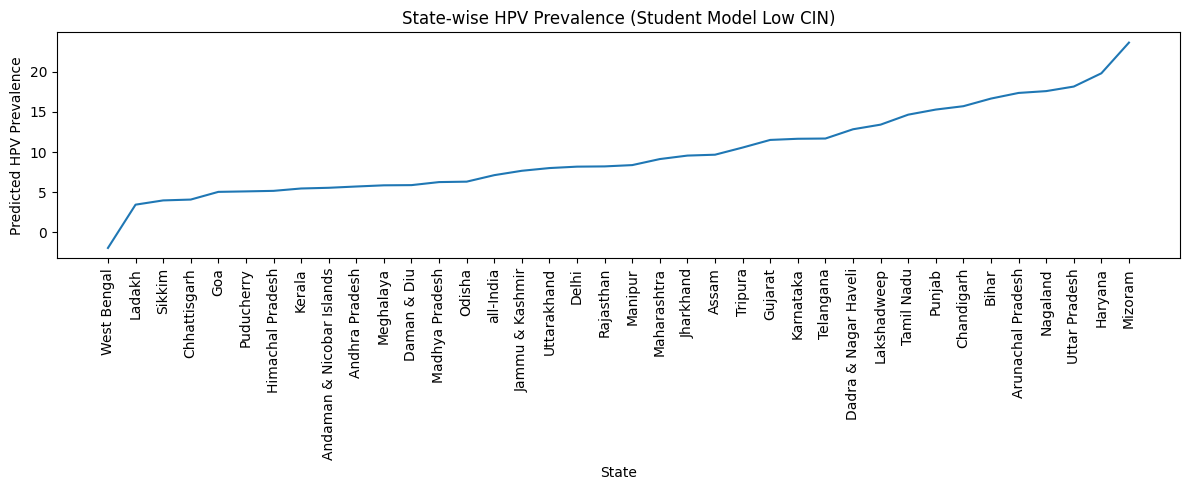

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create results dataframe (consistent with your model output)
student_results = pd.DataFrame({
    "State": states,
    "Predicted_HPV_Prevalence": student_predictions
}).sort_values("Predicted_HPV_Prevalence")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(
    student_results["State"],
    student_results["Predicted_HPV_Prevalence"]
)

plt.xticks(rotation=90)
plt.ylabel("Predicted HPV Prevalence")
plt.xlabel("State")
plt.title("State-wise HPV Prevalence (Student Model Low CIN)")
plt.tight_layout()
plt.show()
